<a href="https://colab.research.google.com/github/Natalia409634/Machine-Learning/blob/main/T9_pipelines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Manejo con pipelines

En este tutorial aprenderemos a trabajar con pipelines y lo mezclaremos con estrategias de optimización de parámetros.

Usaremos el dataset del Titanic donde nos encontraremos con los siguientes temas:
   - Habrá variables nulas
   - Tendremos variables categóricas y numéricas
   - El dataset se encuentra desbalanceado


In [ ]:
%matplotlib inline
#######
# Importamos todas las dependencias
import numpy as np
import matplotlib.pyplot as plt


from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import RobustScaler, OneHotEncoder, OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn import metrics

np.random.seed(42)

X, y = fetch_openml("titanic", version=1, as_frame=True, return_X_y=True)
X.head(10)

/usr/local/lib/python3.9/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1.0,"Allen, Miss. Elisabeth Walton",female,29.0000,0.0,0.0,24160,211.3375,B5,S,2,None,"St Louis, MO"
1,1.0,"Allison, Master. Hudson Trevor",male,0.9167,1.0,2.0,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1.0,"Allison, Miss. Helen Loraine",female,2.0000,1.0,2.0,113781,151.5500,C22 C26,S,None,NaN,"Montreal, PQ / Chesterville, ON"
3,1.0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1.0,2.0,113781,151.5500,C22 C26,S,None,135.0,"Montreal, PQ / Chesterville, ON"
4,1.0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1.0,2.0,113781,151.5500,C22 C26,S,None,NaN,"Montreal, PQ / Chesterville, ON"
5,1.0,"Anderson, Mr. Harry",male,48.0000,0.0,0.0,19952,26.5500,E12,S,3,NaN,"New York, NY"
6,1.0,"Andrews, Miss. Kornelia Theodosia",female,63.0000,1.0,0.0,13502,77.9583,D7,S,10,NaN,"Hudson, NY"
7,1.0,"Andrews, Mr. Thomas Jr",male,39.0000,0.0,0.0,112050,0.0000,A36,S,None,NaN,"Belfast, NI"
8,1.0,"Appleton, Mrs. Edward Dale (Charlotte Lamson)",female,53.0000,2.0,0.0,11769,51.4792,C101,S,D,NaN,"Bayside, Queens, NY"
9,1.0,"Artagaveytia, Mr. Ramon",male,71.0000,0.0,0.0,PC 17609,49.5042,None,C,None,22.0,"Montevideo, Uruguay"


In [ ]:
y.value_counts()

0    809
1    500
Name: survived, dtype: int64

Como vemos este dataset se encuentra algo desbalanceado. Lo tendremos que tener en cuenta en los siguientes momentos:
   - Al dividir en muestras de aprendizaje y test
   - Cuando usemos Cross Validation
   - En el entrenamiento de los modelos. Casi todos los métodos en sklearn admiten un parámetro `class_weight='balanced'`

In [ ]:
# Borramos columnas que no nos interesan
X.drop(['boat', 'body', 'home.dest', 'ticket', 'name'], axis=1, inplace=True)
# Seleccionados train/test en modo stratify, ya que el dataset se encuentra desbalanceado
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2)

In [ ]:
X.describe()

,pclass,age,sibsp,parch,fare
count,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000
mean,2.294882,29.881135,0.498854,0.385027,33.295479
std,0.837836,14.413500,1.041658,0.865560,51.758668
min,1.000000,0.166700,0.000000,0.000000,0.000000
25%,2.000000,21.000000,0.000000,0.000000,7.895800
50%,3.000000,28.000000,0.000000,0.000000,14.454200
75%,3.000000,39.000000,1.000000,0.000000,31.275000
max,3.000000,80.000000,8.000000,9.000000,512.329200


## Tratamiento de valores nulos

In [ ]:
X_train.isnull().any()

pclass      False
sex         False
age          True
sibsp       False
parch       False
fare         True
cabin        True
embarked    False
dtype: bool

In [ ]:
X_train.isnull().sum()

pclass        0
sex           0
age         209
sibsp         0
parch         0
fare          1
cabin       822
embarked      0
dtype: int64

Vamos a dibujar los valores que son nulos

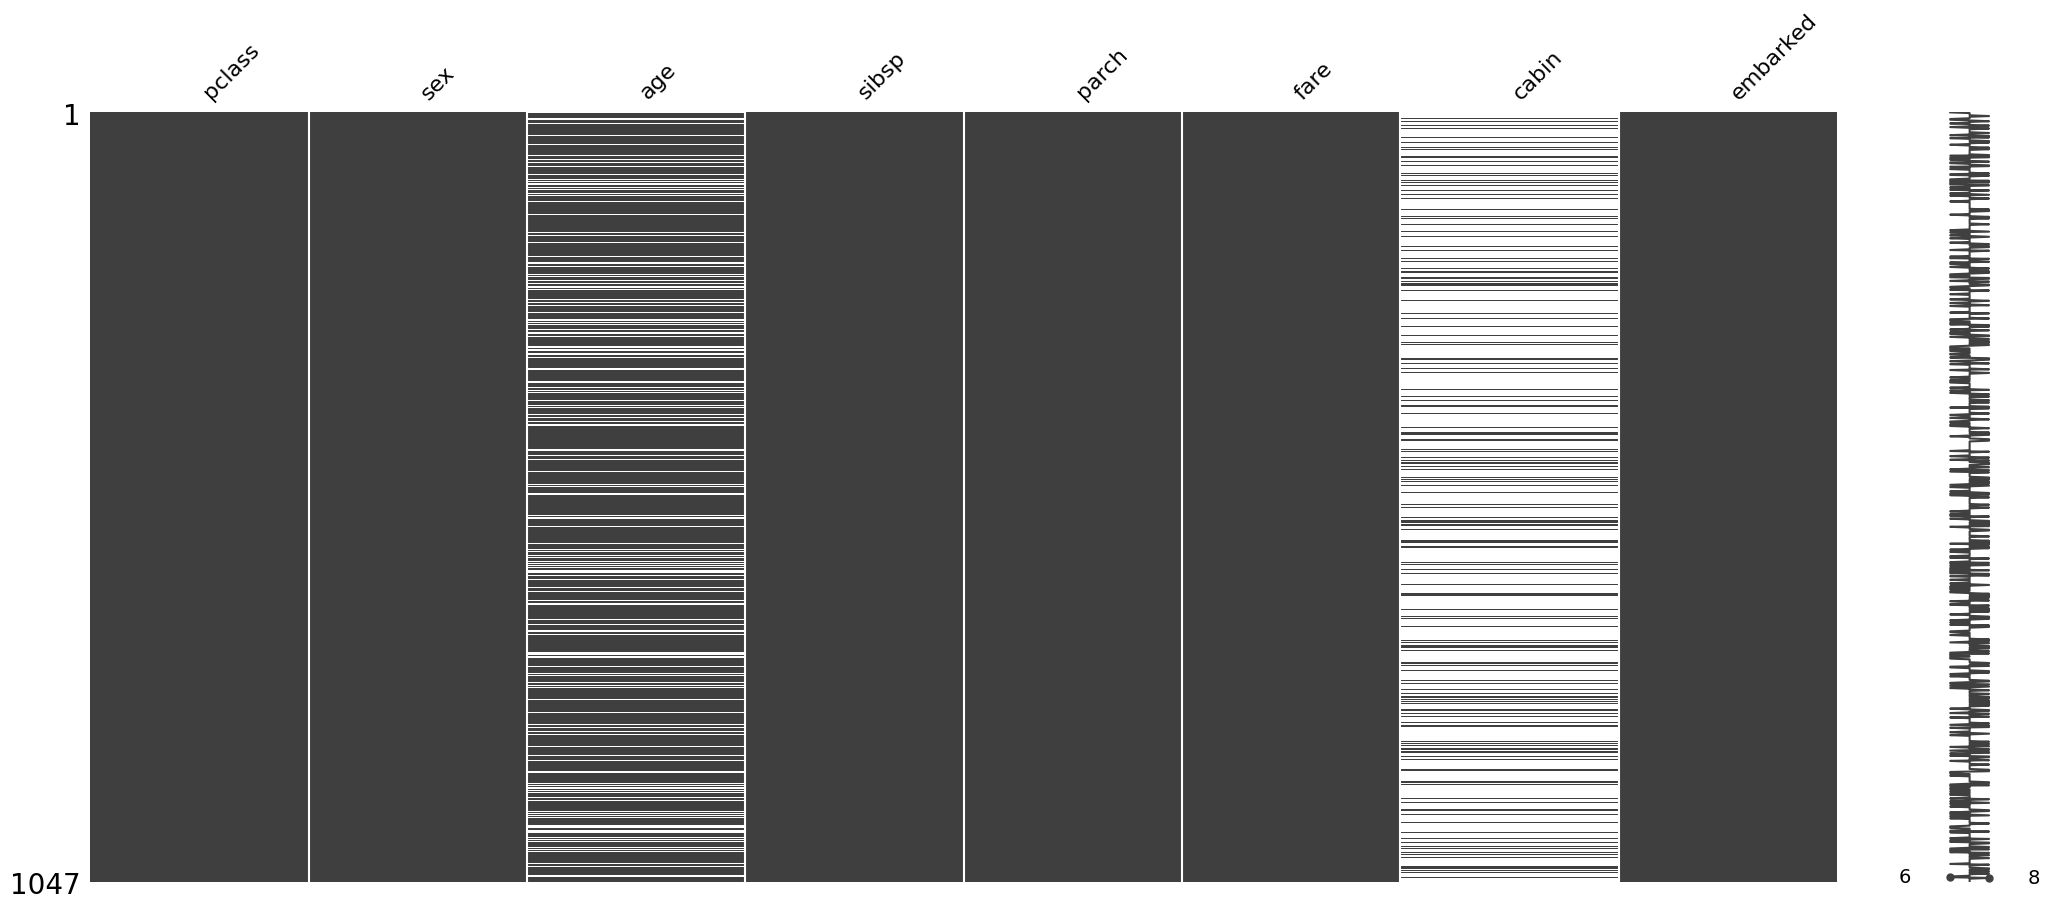

In [ ]:
import missingno as msno
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'png'

msno.matrix(X_train)
plt.show()

In [ ]:
X_train.isnull().sum() / len(X_train) * 100

pclass       0.000000
sex          0.000000
age         19.961796
sibsp        0.000000
parch        0.000000
fare         0.095511
embarked     0.000000
dtype: float64

El atributo 'cabin' tiene demasiados valores nulos. En este caso no tiene sentido aplicar ningún método de imputación, por lo que vamos a eliminar

In [ ]:
X_train.drop(['cabin'], axis=1, inplace=True)
X_test.drop(['cabin'], axis=1, inplace=True)

Vamos a calcular las correlaciones de los valores numéricos

<ipython-input-22-598603a5fca8>:6: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  g = sns.heatmap(X_comb[['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'survived']].corr(),


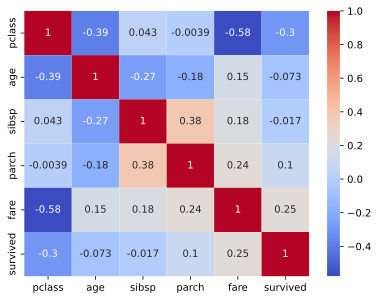

In [ ]:
import pandas as pd
import seaborn as sns
%config InlineBackend.figure_format = 'svg'

X_comb = pd.concat([X_train, y_train.astype(float)], axis=1)
g = sns.heatmap(X_comb[['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'survived']].corr(),
                annot=True, 
                cmap = "coolwarm")

## Codificamos la salida
Aunque la variable de salida es 0 y 1, pasamos a codificarla con `LabelEncoder` ya que para algunas funciones como el cálculo de las curvas ROC necesitamos esta codificación. 

In [ ]:
# Es necesario 
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(y)

y_test = le.transform(y_test)
y_train = le.transform (y_train)

## Analizar tipos de variables
Vamos a analizar las variables categóricas que tenemos en el dataset

In [ ]:
X_train.dtypes

pclass       float64
sex         category
age          float64
sibsp        float64
parch        float64
fare         float64
cabin         object
embarked    category
dtype: object

In [ ]:
cat_cols = X_train.select_dtypes(include="category").columns
num_cols = X_train.select_dtypes(exclude="category").columns

In [ ]:
cat_cols

Index(['sex', 'embarked'], dtype='object')

Para las variables categóticas vamos a crear un pipeline donde:
1. Si hubiese una muestra con valores nulos, le vamos a imputar el valor del más frecuente.
2. Codificaremos con la técnicas One_Hot_Encoder.
3. Aplicaremos sobre ellos un PCA, para extraer características más discriminantes

In [ ]:
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False)),
    ('pca', PCA(n_components=5))
])

In [ ]:
# Si queremos acceder al primer paso del pipeline. De la misma forma podríamos acceder a los distintos pasos del pipeline
cat_transformer[0]

SimpleImputer(strategy='most_frequent')

Ahora nos metemos con las variables numéricas. En este caso vamos a realizar el siguiente preproceso:
1. Si hay valores nulos, vamos a asignarles la media de sus K=5 vecinos más cercanos.
2. Realizaremos un escalado

In [ ]:
from sklearn.impute import KNNImputer
from sklearn.preprocessing import RobustScaler

num_transformer = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=5)),
    ('scaler', RobustScaler())
])

En el siguiente código vamos a utilizar la función `ColumnTransformer` para indicar cómo vamos a preprocesar a las variables categóricas y numéricas

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_cols),
        ('cat', cat_transformer, cat_cols)
    ])
       

In [ ]:
preprocessor


ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer', KNNImputer()),
                                                 ('scaler', RobustScaler())]),
                                 Index(['pclass', 'age', 'sibsp', 'parch', 'fare', 'cabin'], dtype='object')),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False)),
                                                 ('pca', PCA(n_components=7))]),
                                 Index(['sex', 'embarked'], dtype='object'))])

## Creamos el clasificador
Por último, vamos a crear un `Pipeline` para unir el paso del preproceso, con el paso de entrenamiento del modelo. Fijaros que en el entrenamiento del modelo estoy indicando `class_weight='balanced'`, ya que el dataset se encuentra desbalanceado.

In [ ]:
from sklearn.model_selection import cross_val_score
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', RandomForestClassifier(class_weight='balanced'))])

Si el valor del parámetro es `cv` asignado a un número entero y la variable de salida es binaria o multiclase, entonces utiliza `StratifiedKFold`. Directamente utiliza el valor de `shuffle=False`.
En este caso, lleva a cabo un `StratifiedKFold` con K=5, y obtenemos el valor medio del `accuracy`.

In [ ]:
clf

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   KNNImputer()),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  Index(['pclass', 'age', 'sibsp', 'parch', 'fare', 'cabin'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False)),
                                                                  ('pca',
                                                                   PCA(n_components=7))]),
                                                  Index(['sex', 'embarked'], dtype='object'))])),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced'))])

In [ ]:
cross_val_score(clf, X_train, y_train, cv=5, scoring="accuracy").mean()

0.7821918432444748

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

num_transformer_dist = {'preprocessor__num__imputer__n_neighbors': list(range(2, 15)),
                        'preprocessor__num__imputer__add_indicator': [True, False]}

cat_transformer_dist = {'preprocessor__cat__imputer__strategy': ['most_frequent', 'constant'],
                        'preprocessor__cat__imputer__add_indicator': [True, False],
                        'preprocessor__cat__pca__n_components': list(range(2, 5))}

random_forest_dist = {'classifier__n_estimators': list(range(50, 500)),
                      'classifier__max_depth': list(range(2, 20)),
                      'classifier__bootstrap': [True, False]}

param_dist = {**num_transformer_dist, **cat_transformer_dist, **random_forest_dist}

random_search = RandomizedSearchCV(clf,
                                   param_distributions=param_dist,
                                   n_iter=100)

In [ ]:
random_search.fit(X_train, y_train)

RandomizedSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                KNNImputer()),
                                                                                               ('scaler',
                                                                                                RobustScaler())]),
                                                                               Index(['pclass', 'age', 'sibsp', 'parch', 'fare'], dtype='object')),
                                                                              ('cat',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('onehot',
                                                                                                OneHotEncoder(handle_unknown='ign...
                                                                     65, 66, 67,
                                                                     68, 69, 70,
                                                                     71, 72, 73,
                                                                     74, 75, 76,
                                                                     77, 78, 79, ...],
                                        'preprocessor__cat__imputer__add_indicator': [True,
                                                                                      False],
                                        'preprocessor__cat__imputer__strategy': ['most_frequent',
                                                                                 'constant'],
                                        'preprocessor__cat__pca__n_components': [2,
                                                                                 3,
                                                                                 4],
                                        'preprocessor__num__imputer__add_indicator': [True,
                                                                                      False],
                                        'preprocessor__num__imputer__n_neighbors': [2,
                                                                                    3,
                                                                                    4,
                                                                                    5,
                                                                                    6,
                                                                                    7,
                                                                                    8,
                                                                                    9,
                                                                                    10,
                                                                                    11,
                                                                                    12,
                                                                                    13,
                                                                                    14]})

In [ ]:
random_search.best_score_

0.8013670539986328

In [ ]:
random_search.best_params_

{'preprocessor__num__imputer__n_neighbors': 13,
 'preprocessor__num__imputer__add_indicator': False,
 'preprocessor__cat__pca__n_components': 2,
 'preprocessor__cat__imputer__strategy': 'constant',
 'preprocessor__cat__imputer__add_indicator': False,
 'classifier__n_estimators': 150,
 'classifier__max_depth': 7,
 'classifier__bootstrap': False}

In [ ]:
y_pred = random_search.predict(X_test)
y_pred[:5]

array(['0', '1', '0', '0', '0'], dtype=object)

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.85      0.85       162
           1       0.75      0.76      0.76       100

    accuracy                           0.81       262
   macro avg       0.80      0.80      0.80       262
weighted avg       0.81      0.81      0.81       262



La precisión balanceada se usa en problemas de clasificación binaria y multiclase para tratar conjuntos de datos desbalanceados. Se define como la media del recall obtenido en cada clase.

In [ ]:
from sklearn.metrics import balanced_accuracy_score

print(f"El valor de balanced accuracy: {balanced_accuracy_score(y_test, y_pred)}")


El valor de balanced accuracy: 0.8028395061728395


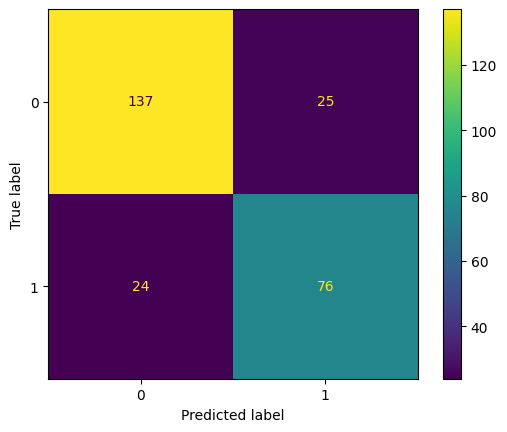

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

cm = confusion_matrix(y_test, y_pred, labels=random_search.classes_)
disp= ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=random_search.classes_)
disp.plot()
plt.show()

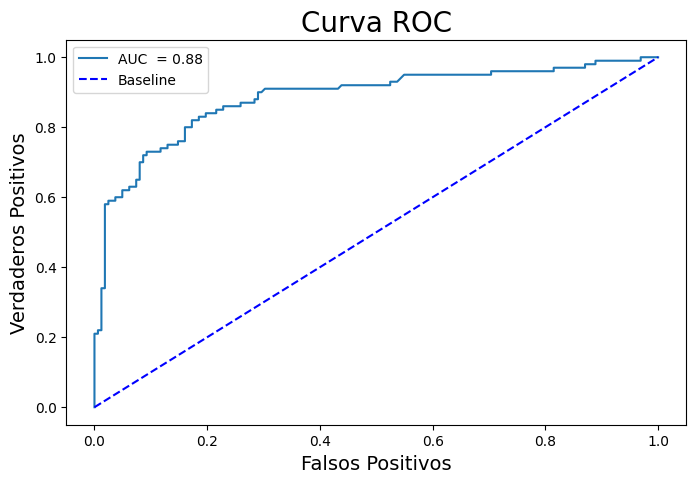

In [ ]:
#Obtenemos las curva ROC y el área bajo la curva (AUC)

probs = random_search.predict_proba(X_test)[:, 1]

auc = metrics.roc_auc_score(y_test, probs)
fpr, tpr, thresholds = metrics.roc_curve(y_test, probs)

plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label=f'AUC  = {auc:.2f}')
plt.plot([0, 1], [0, 1], color='blue', linestyle='--', label='Baseline')
plt.title('Curva ROC', size=20)
plt.xlabel('Falsos Positivos', size=14)
plt.ylabel('Verdaderos Positivos', size=14)
plt.legend();

In [ ]:
# Modelo final
modelo_final = random_search.best_estimator_
_ = modelo_final.fit (X,y)
